In [1]:
import torch

import numpy as np
import math
 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [33]:
# Parameters
dt = 5e-2
num_ghost = 2048
tol = 1e-8

mu = 1

# Physical Dimension
x_dim = 2
output_dim = 2

periodic1 = { 'variable':'x', 
              'base':-math.pi,
              'top':math.pi }

periodic2 = { 'variable':'y', 
              'base':-math.pi,
              'top':math.pi }

list_of_periodic_boundaries =[periodic1, periodic2]

class bdry_periodic:

    def __init__(self, variable, base, top):
        
        if variable == 'x':
            self.index = 0
        if variable == 'y':
            self.index = 1
        if variable == 'z':
            self.index = 2

        self.base = base
        self.top = top

my_periodic_boundaries = []
for specs in list_of_periodic_boundaries:
    my_periodic_boundaries.append( bdry_periodic( variable = specs['variable'],
                                                    base = specs['base'],
                                                    top = specs['top']  ))


In [3]:
def true_pressure(x):
    p = -1/4 * (torch.cos(2*x[:,0]) + torch.cos(2*x[:,1]))*torch.exp(-4*mu*x[:,2])
    return p

def shifted_pressure(x):
    ### zero at point (0,0)

    x0 = torch.stack( ( torch.zeros((x.shape[0], 2)), x[:,-1] ), dim=1)

    p = true_pressure(x) - true_pressure(x0)

    return p

def true_solution(X):
    u = torch.stack( ( torch.cos(X[:,0])*torch.sin(X[:,1])*torch.exp(-2*mu*X[:,2]),
                      -torch.sin(X[:,0])*torch.cos(X[:,1])*torch.exp(-2*mu*X[:,2]) ), dim=1)
    return u

def true_pressure_gradient(x):

    p1 = 1/2 * (torch.sin(2*x[:,0]))*torch.exp(-4*mu*x[:,2])
    p2 = 1/2 * (torch.sin(2*x[:,1]))*torch.exp(-4*mu*x[:,2])

    return torch.stack((p1,p2), dim=1)


In [36]:

def periodic_condition(Xnew, periodic_boundaries):
    for bdry in periodic_boundaries:
        below_base = Xnew[:,bdry.index] < bdry.base
        above_top = Xnew[:,bdry.index] > bdry.top

        if torch.any(below_base):
            Xnew[below_base, bdry.index] = Xnew[below_base, bdry.index] + (bdry.top - bdry.base)
        if torch.any(above_top):
            Xnew[above_top,bdry.index] = Xnew[above_top, bdry.index] - (bdry.top - bdry.base)
    return Xnew

def find_time_exit(Xold, Xnew, tol):
    ### Bisection algorithm to find the time exit up to a tolerance
    
    Xmid = (Xnew + Xold)/2

    # above tolerance = inside
    # below tolerance = outside
    above_tol = Xmid[:,-1] > tol
    below_tol = Xmid[:,-1] < -tol

    if torch.any(above_tol + below_tol):
        Xnew[below_tol,:] = Xmid[below_tol,:]
        Xold[above_tol,:] = Xmid[above_tol,:]
        
        Xmid[above_tol + below_tol,:] = find_time_exit(Xold[above_tol + below_tol,:], Xnew[above_tol + below_tol,:], tol)

    return Xmid
    
def move_walkers(Xold):
    numpts = Xold.shape[0]

    ### Generate points -- requires grad

    ### Move Walkers
    Uold = true_solution(Xold)

    Zt = np.sqrt(dt)*torch.randn((numpts*num_ghost, x_dim))

    Xnew = Xold.repeat(num_ghost,1)  + torch.cat( (-dt*Uold.repeat(num_ghost,1) + np.sqrt(2*mu)*Zt, 
                                                   -dt*torch.ones((numpts*num_ghost,1))), dim=1)


    ### Initial condition
    #hit_initial = Xnew[:,-1] < 0
    #Xnew[hit_initial,:] = find_time_exit(Xold.repeat(num_ghost,1)[hit_initial,:], Xnew[hit_initial,:], tol)

    ### Calculate periodic boundaries
    Xnew = periodic_condition(Xnew, my_periodic_boundaries)

    return Xnew

def evaluate_terms(Xold, separate_random=False):

    numpts = Xold.shape[0]

    if separate_random:
        Uold = true_solution(Xold)
        gradPold = true_pressure_gradient(Xold)

        Xnew = move_walkers(Xold)
        Unew = true_solution(Xnew).reshape(num_ghost, numpts, output_dim).mean(0)

        Xnew = move_walkers(Xold)
        gradPnew = true_pressure_gradient(Xnew).reshape(num_ghost, numpts, output_dim).mean(0)


    else:
        Uold = true_solution(Xold)
        gradPold = true_pressure_gradient(Xold)

        Xnew = move_walkers(Xold)
        Unew = true_solution(Xnew).reshape(num_ghost, numpts, output_dim).mean(0)
        gradPnew = true_pressure_gradient(Xnew).reshape(num_ghost, numpts, output_dim).mean(0)

    return Uold, Unew, gradPold, gradPnew
    

In [37]:
####################### Plotting and Error Parameters ########################
numpts_x = 64
numpts_y =  64

numpts_time = 50

xplot, yplot = torch.meshgrid( torch.linspace(-math.pi,math.pi,numpts_x),
                               torch.linspace(-math.pi,math.pi,numpts_y))

xg = torch.stack( (xplot.reshape(-1), yplot.reshape(-1), torch.zeros(numpts_x*numpts_y) ), dim=1)

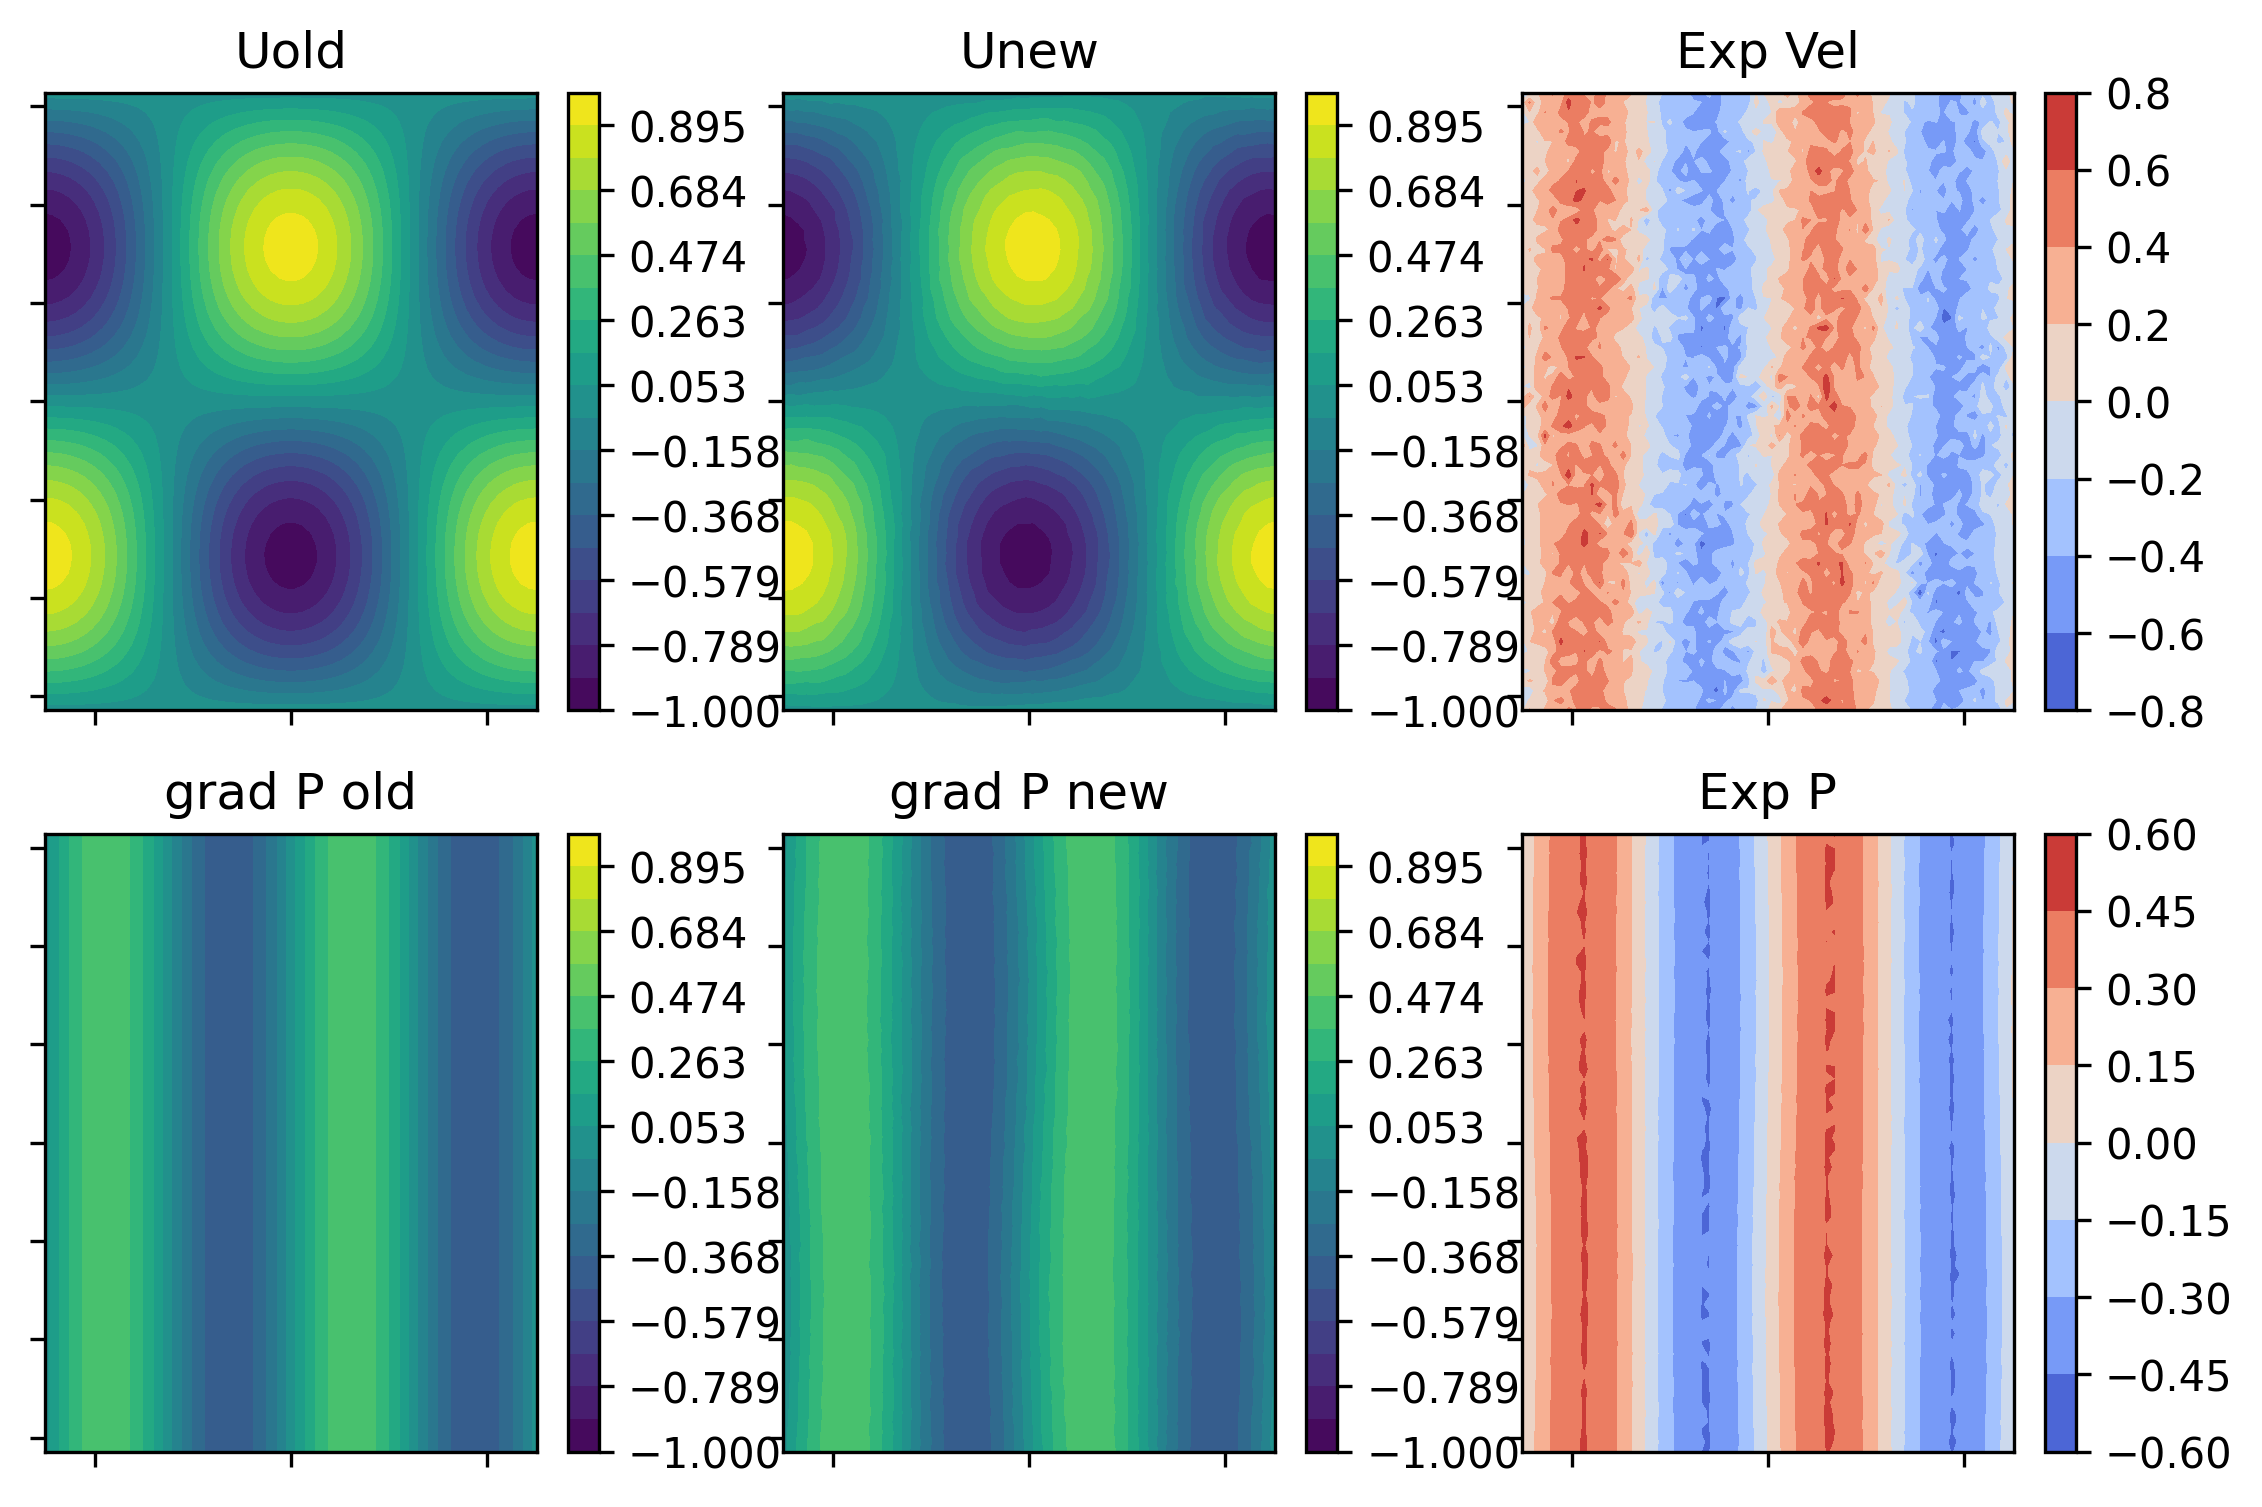

In [38]:
plt.close('all')
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[9, 6])

levels_flow = np.linspace(-1.0, 1.0, 20)

# Times
xg[:,2] = 0.025

Uold, Unew, gradPold, gradPnew = evaluate_terms(xg)

U1old = Uold.reshape(numpts_x, numpts_y, 2).numpy()[:,:,0]
U1new = Unew.reshape(numpts_x, numpts_y, 2).numpy()[:,:,0]

gradP1old = gradPold.reshape(numpts_x, numpts_y, 2).numpy()[:,:,0]
gradP1new = gradPnew.reshape(numpts_x, numpts_y, 2).numpy()[:,:,0]


contour0 = ax[0,0].contourf(xplot.numpy(), yplot.numpy(), U1old, levels_flow , cmap=plt.cm.viridis)
ax[0,0].set_title(r'Uold')
ax[0,0].set_xticklabels([])
ax[0,0].set_yticklabels([])
plt.colorbar(contour0, ax=ax[0,0])

contour1 = ax[0,1].contourf(xplot.numpy(), yplot.numpy(), U1new, levels_flow , cmap=plt.cm.viridis)
ax[0,1].set_title(r'Unew')
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
plt.colorbar(contour1, ax=ax[0,1])

contour2 = ax[0,2].contourf(xplot.numpy(), yplot.numpy(), (U1new - U1old)/dt, cmap=plt.cm.coolwarm)
ax[0,2].set_title(r'Exp Vel')
ax[0,2].set_xticklabels([])
ax[0,2].set_yticklabels([])
plt.colorbar(contour2, ax=ax[0,2])

contour3 = ax[1,0].contourf(xplot.numpy(), yplot.numpy(), gradP1old, levels_flow , cmap=plt.cm.viridis)
ax[1,0].set_title(r'grad P old')
ax[1,0].set_xticklabels([])
ax[1,0].set_yticklabels([])
plt.colorbar(contour3, ax=ax[1,0])

contour4 = ax[1,1].contourf(xplot.numpy(), yplot.numpy(), gradP1new, levels_flow , cmap=plt.cm.viridis)
ax[1,1].set_title(r'grad P new')
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])
plt.colorbar(contour4, ax=ax[1,1])

contour5 = ax[1,2].contourf(xplot.numpy(), yplot.numpy(), (gradP1new + gradP1old)/2, cmap=plt.cm.coolwarm)
ax[1,2].set_title(r'Exp P')
ax[1,2].set_xticklabels([])
ax[1,2].set_yticklabels([])
plt.colorbar(contour5, ax=ax[1,2])

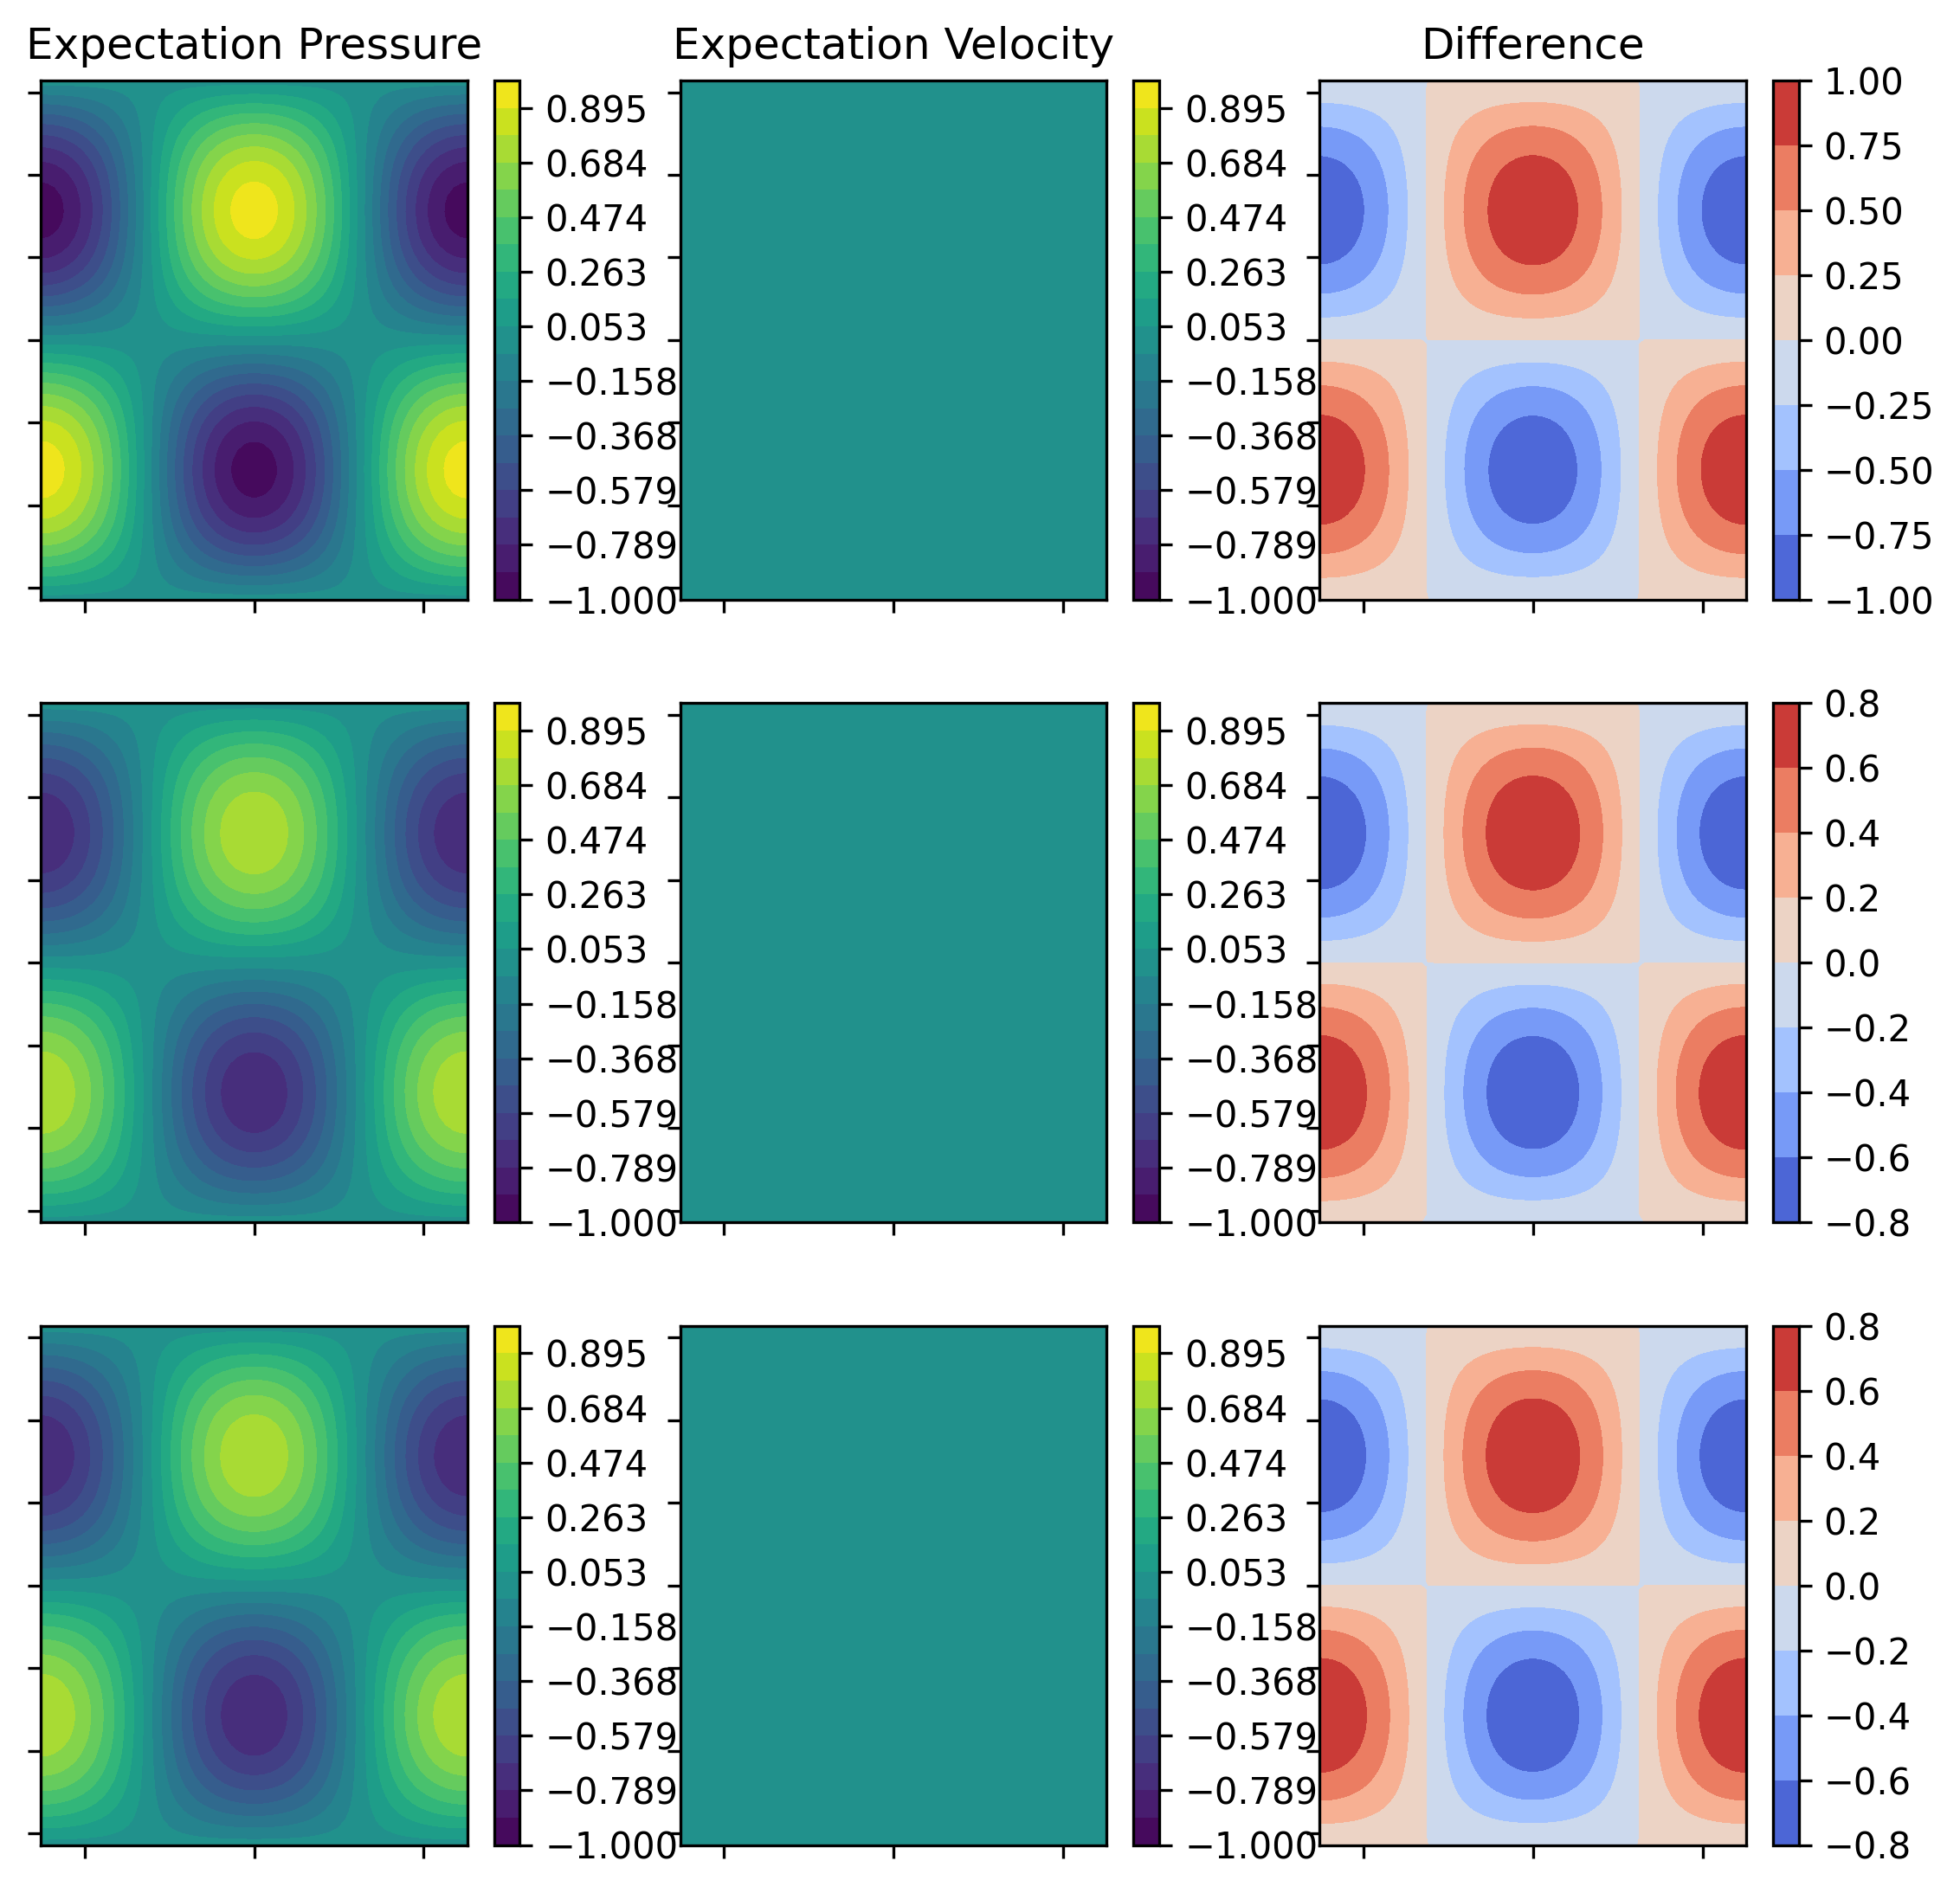

In [9]:
plt.close('all')
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[9, 9])

levels_flow = np.linspace(-1.0, 1.0, 20)

### Different Times

# t = 0.025
xg[:,2] = 0.025

Uold, Unew, Pold, Pnew = evaluate_terms(xg)

LHS = Uold.reshape(numpts_x, numpts_y, 2)
RHS = Unew.reshape(numpts_x, numpts_y, 2)

#RHS = (Unew - Uold).reshape(numpts_x, numpts_y, 2)
#LHS = (Pnew - Pold).reshape(numpts_x, numpts_y, 2)*dt/2

#target = (Pnew.reshape(numpts_x, numpts_y, 2) - 2*RHS/dt)

contour0 = ax[0,0].contourf(xplot.numpy(), yplot.numpy(), LHS[:,:,0], levels_flow , cmap=plt.cm.viridis)
ax[0,0].set_title(r'Expectation Pressure')
ax[0,0].set_xticklabels([])
ax[0,0].set_yticklabels([])
plt.colorbar(contour0, ax=ax[0,0])

contour1 = ax[0,1].contourf(xplot.numpy(), yplot.numpy(), RHS[:,:,0], levels_flow , cmap=plt.cm.viridis)
ax[0,1].set_title(r'Expectation Velocity')
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
plt.colorbar(contour1, ax=ax[0,1])

contour2 = ax[0,2].contourf(xplot.numpy(), yplot.numpy(), LHS[:,:,0] - RHS[:,:,0], cmap=plt.cm.coolwarm)
ax[0,2].set_title(r'Difference')
ax[0,2].set_xticklabels([])
ax[0,2].set_yticklabels([])
plt.colorbar(contour2, ax=ax[0,2])

# t = 0.125
xg[:,2] = 0.125

Uold, Unew, Pold, Pnew = evaluate_terms(xg)

LHS = Uold.reshape(numpts_x, numpts_y, 2)
RHS = Unew.reshape(numpts_x, numpts_y, 2)

#RHS = (Unew - Uold).reshape(numpts_x, numpts_y, 2)
#LHS = (Pnew - Pold).reshape(numpts_x, numpts_y, 2)*dt/2

#target = (Pnew.reshape(numpts_x, numpts_y, 2) - 2*RHS/dt)

tick_trained = [np.amin(LHS), np.amax( LHS)]
tick_true = [np.amin(RHS), np.amax( RHS)]

contour3 = ax[1,0].contourf(xplot, yplot, LHS[:,:,0], levels_flow, cmap=plt.cm.viridis)
ax[1,0].set_xticklabels([])
ax[1,0].set_yticklabels([])
plt.colorbar(contour3, ax=ax[1,0])

contour4 = ax[1,1].contourf(xplot, yplot, RHS[:,:,0], levels_flow, cmap=plt.cm.viridis)
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])
plt.colorbar(contour4, ax=ax[1,1])

contour5 = ax[1,2].contourf(xplot, yplot, LHS[:,:,0] - RHS[:,:,0], cmap=plt.cm.coolwarm)
ax[1,2].set_xticklabels([])
ax[1,2].set_yticklabels([])
plt.colorbar(contour5, ax=ax[1,2])

# t = 0.25

Uold, Unew, Pold, Pnew = evaluate_terms(xg)

LHS = Uold.reshape(numpts_x, numpts_y, 2)
RHS = Unew.reshape(numpts_x, numpts_y, 2)

#RHS = (Unew - Uold).reshape(numpts_x, numpts_y, 2)
#LHS = (Pnew - Pold).reshape(numpts_x, numpts_y, 2)*dt/2

#target = (Pnew.reshape(numpts_x, numpts_y, 2) - 2*RHS/dt)

tick_trained = [np.amin(LHS), np.amax( LHS)]
tick_true = [np.amin(RHS), np.amax( RHS)]

contour6 = ax[2,0].contourf(xplot, yplot, LHS[:,:,0], levels_flow, cmap=plt.cm.viridis)
ax[2,0].set_xticklabels([])
ax[2,0].set_yticklabels([])
plt.colorbar(contour6, ax=ax[2,0])

contour7 = ax[2,1].contourf(xplot, yplot, RHS[:,:,0], levels_flow, cmap=plt.cm.viridis)
ax[2,1].set_xticklabels([])
ax[2,1].set_yticklabels([])
plt.colorbar(contour7, ax=ax[2,1])

contour8 = ax[2,2].contourf(xplot, yplot, LHS[:,:,0] - RHS[:,:,0], cmap=plt.cm.coolwarm)
ax[2,2].set_xticklabels([])
ax[2,2].set_yticklabels([])
plt.colorbar(contour8, ax=ax[2,2])